In [11]:
import geopandas as gpd
import pandas as pd
import momepy

In [2]:
path = "/Users/martin/Library/CloudStorage/GoogleDrive-fleischma@natur.cuni.cz/Shared drives/US CUNI/Data/2024_building_footprints/OSM_no_overlap_collapse.parquet"

In [3]:
blgs=gpd.read_parquet(path)

In [4]:
blgs

,geometry
0,"POLYGON ((4588533.734 5821521.726, 4588570.786..."
1,"POLYGON ((4591889.97 5823105.866, 4591898.467 ..."
2,"POLYGON ((4592002.064 5821961.774, 4592000.684..."
3,"POLYGON ((4592077.946 5822437.286, 4592070.997..."
4,"POLYGON ((4592403.073 5822915.869, 4592383.652..."
...,...
1056204,"POLYGON ((4599145.094 5819669.998, 4599129.491..."
1056205,"POLYGON ((4576136.11 5806949.507, 4576173.534 ..."
1056206,"POLYGON ((4586760.398 5822967.926, 4586762.549..."
1056207,"POLYGON ((4597976.059 5812604.354, 4597984.496..."


In [5]:
check=momepy.CheckTessellationInput(blgs)

Collapsed features  : 0
Split features      : 414
Overlapping features: 0


In [52]:
# blgs.cx[4592061.95209169:4597983.994257349, 5818788.000805501:5823292.416639388].explore()

In [7]:
blgs.boundary

0          LINESTRING (4588533.734 5821521.726, 4588570.7...
1          LINESTRING (4591889.97 5823105.866, 4591898.46...
2          LINESTRING (4592002.064 5821961.774, 4592000.6...
3          LINESTRING (4592077.946 5822437.286, 4592070.9...
4          LINESTRING (4592403.073 5822915.869, 4592383.6...
                                 ...                        
1056204    LINESTRING (4599145.094 5819669.998, 4599129.4...
1056205    MULTILINESTRING ((4576136.11 5806949.507, 4576...
1056206    LINESTRING (4586760.398 5822967.926, 4586762.5...
1056207    LINESTRING (4597976.059 5812604.354, 4597984.4...
1056208    MULTILINESTRING ((4598421.808 5812616.361, 459...
Length: 1056209, dtype: geometry

In [8]:
%time nearby_a, nearby_b = blgs.sindex.query(blgs.geometry, predicate="dwithin", distance=0.5)
%time overlap_a, overlap_b = blgs.boundary.sindex.query(blgs.boundary, predicate="overlaps")

CPU times: user 4.5 s, sys: 36.4 ms, total: 4.53 s
Wall time: 4.58 s
CPU times: user 35.4 s, sys: 529 ms, total: 35.9 s
Wall time: 36.6 s


In [16]:
self_mask = nearby_a != nearby_b
nearby_a = nearby_a[self_mask]
nearby_b = nearby_b[self_mask]

self_mask = overlap_a != overlap_b
overlap_a = overlap_a[self_mask]
overlap_b = overlap_b[self_mask]

In [17]:
nearby = pd.MultiIndex.from_arrays([nearby_a, nearby_b], names=('source', 'target'))
overlap = pd.MultiIndex.from_arrays([overlap_a, overlap_b], names=('source', 'target'))

In [18]:
nearby_not_overlap = nearby.difference(overlap)

In [20]:
nearby_not_overlap

MultiIndex([(      6,      51),
            (      6,  105283),
            (     19,  377508),
            (     30,     124),
            (     31,    9612),
            (     45,     124),
            (     46,     124),
            (     48,      50),
            (     50,      48),
            (     51,       6),
            ...
            (1055967,  938379),
            (1055970,  962015),
            (1056072, 1007029),
            (1056100,  289639),
            (1056103,  156623),
            (1056133,  656798),
            (1056137, 1056138),
            (1056138, 1056137),
            (1056145,   91958),
            (1056177,   72168)],
           names=['source', 'target'], length=49940)

<Axes: >

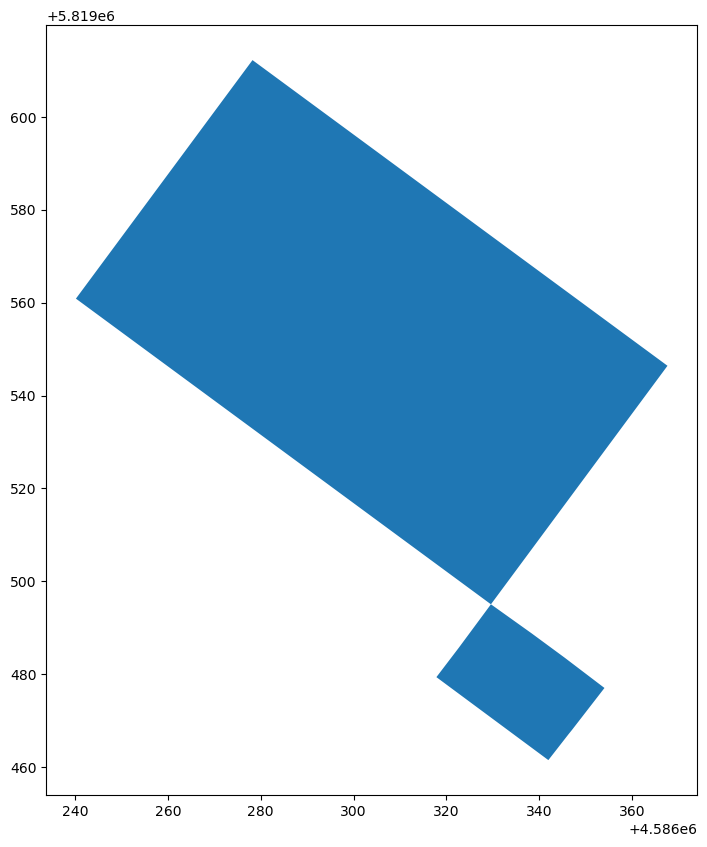

In [45]:
blgs.iloc[[31, 9612]].plot(figsize=(10, 10))

In [39]:
blgs.iloc[1056100].geometry.intersection(blgs.iloc[289639].geometry).wkt

/Users/martin/miniforge3/envs/momepy/lib/python3.11/site-packages/shapely/set_operations.py:131: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


'POINT (4595588.662430685 5822299.378515491)'

In [29]:
def _snap(geometry, reference, threshold, segment_length):
    """Snap g1 to g2 within threshold

    Parameters
    ----------
    geometry : shapely.Polygon
        geometry to snap
    reference : shapely.Polygon
        geometry to snap to
    threshold : float
        max distance between vertices to snap
    segment_length : float
        max segment length parameter in segmentize

    Returns
    -------
    shapely.Polygon
        snapped geometry
    """
    import shapely

    # extract the shell and holes from the first geometry
    shell, holes = geometry.exterior, geometry.interiors
    # segmentize the shell and extract coordinates
    coords = shapely.get_coordinates(shapely.segmentize(shell, segment_length))
    # create a point geometry from the coordinates
    points = shapely.points(coords)
    # find the shortest line between the points and the second geometry
    lines = shapely.shortest_line(points, reference)
    # mask the coordinates where the distance is less than the threshold
    distance_mask = shapely.length(lines) < threshold
    # update the coordinates with the snapped coordinates
    coords[distance_mask] = shapely.get_coordinates(lines)[1::2][distance_mask]
    # re-create the polygon with new coordinates and original holes and simplify to remove any extra vertices
    return shapely.simplify(shapely.Polygon(coords, holes=holes), segment_length / 100)

In [50]:
new = _snap(blgs.geometry.iloc[31], blgs.geometry.iloc[9612], 0.5, 0.5)

<Axes: >

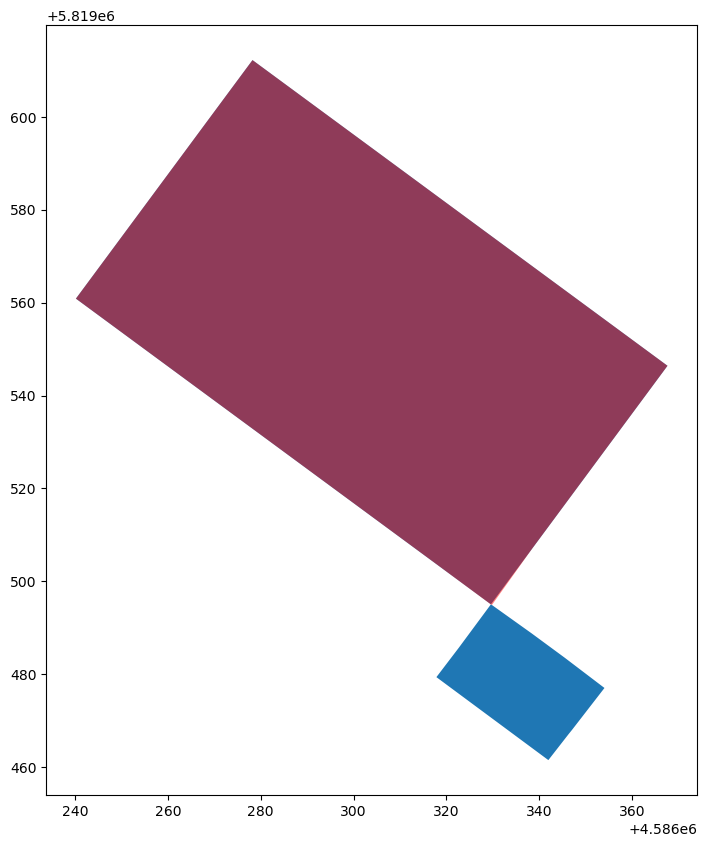

In [51]:
ax = blgs.iloc[[31, 9612]].plot(figsize=(10, 10))
gpd.GeoSeries([new]).plot(ax=ax, color='red', alpha=0.5)